# Car accident

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import chardet
import datetime
import os
from tueplots import bundles
from tueplots.constants.color import rgb
import sklearn as sk
from sklearn.decomposition import PCA
import seaborn as sns
import dload
import geopandas

plt.rcParams.update(bundles.beamer_moml())
plt.rcParams.update({"figure.dpi": 200})

if not os.path.exists('Graphen'):
    os.mkdir('Graphen')
if not os.path.exists('Daten'):
    os.mkdir('Daten')

In [43]:
#dload.save_unzip('https://static.nhtsa.gov/nhtsa/downloads/FARS/2020/National/FARS2020NationalCSV.zip')
try:
    accidents = pd.read_csv('FARS2021NationalCSV/accident.csv',encoding='WINDOWS-1252')
except:
    with open('FARS2021NationalCSV/accident.csv', 'rb') as f:
        result = chardet.detect(f.read())  # or readline if the file is large
    accidents = pd.read_csv('FARS2021NationalCSV/accident.csv',encoding=result)
    print(result)
accidents['date'] = pd.to_datetime(accidents[['YEAR','MONTH','DAY']])


try:
    people = pd.read_csv('Daten/people.csv',index_col=0)
except:
    people = pd.read_csv('https://www2.census.gov/programs-surveys/popest/datasets/2020-2021/counties/totals/co-est2021-alldata.csv',encoding='ISO-8859-10')
    people.to_csv('Daten/people.csv')
    
try:
    Google_daten = pd.read_csv('Daten/Google_daten(US).csv',parse_dates=['date'],index_col=0)
except:
    Google_daten = pd.read_csv('https://storage.googleapis.com/covid19-open-data/v2/main.csv',skiprows=range(1,14096993),nrows=2368485,parse_dates=['date'])
    Google_daten.sort_values(by=['subregion1_name','date'])
    Google_daten.to_csv('Daten/Google_daten(US).csv')

US_state_shape = geopandas.read_file('Daten/States shape data/cb_2018_us_state_500k.shp')
US_state_shape['STATENAME'] = US_state_shape['NAME']
print(US_state_shape.head())

#remove unnecessary data
Google_daten = Google_daten[Google_daten['date']>'2021'] #no data from years before 2021 is needed
Google_daten = Google_daten[Google_daten['date']<'2022'] #no data from years after 2021 is needed
#Google_daten.to_csv('Daten/Google_daten(US).csv')
Google_daten = Google_daten.groupby(by=['subregion1_name','date']).first().reset_index()    # delete countys


print(people[people['CTYNAME'].isin(people['STNAME'])][['STATE','CTYNAME','POPESTIMATE2021']].groupby('STATE').first())
print(accidents.columns)
print(accidents)

save_Google = Google_daten.copy()
save_US = US_state_shape.copy()

/tmp/ipykernel_15438/3210114672.py:19: DtypeWarning: Columns (12,13,103) have mixed types. Specify dtype option on import or set low_memory=False.
  Google_daten = pd.read_csv('Daten/Google_daten(US).csv',parse_dates=['date'],index_col=0)


  STATEFP   STATENS     AFFGEOID GEOID STUSPS            NAME LSAD  \
0      28  01779790  0400000US28    28     MS     Mississippi   00   
1      37  01027616  0400000US37    37     NC  North Carolina   00   
2      40  01102857  0400000US40    40     OK        Oklahoma   00   
3      51  01779803  0400000US51    51     VA        Virginia   00   
4      54  01779805  0400000US54    54     WV   West Virginia   00   

          ALAND       AWATER  \
0  121533519481   3926919758   
1  125923656064  13466071395   
2  177662925723   3374587997   
3  102257717110   8528531774   
4   62266474513    489028543   

                                            geometry       STATENAME  
0  MULTIPOLYGON (((-88.50297 30.21523, -88.49176 ...     Mississippi  
1  MULTIPOLYGON (((-75.72681 35.93584, -75.71827 ...  North Carolina  
2  POLYGON ((-103.00257 36.52659, -103.00219 36.6...        Oklahoma  
3  MULTIPOLYGON (((-75.74241 37.80835, -75.74151 ...        Virginia  
4  POLYGON ((-82.64320 38.16909

In [46]:
Google_daten = save_Google.copy()
#print(Google_daten)
Google_daten['STATENAME'] = Google_daten['subregion1_name']
Google_daten = Google_daten.groupby(by=['subregion1_name','date']).first().reset_index()
Google_daten = Google_daten.sort_values(by=['subregion1_name','date'])
temp = accidents
#print(temp['subregion1_name'].unique())
#print(Google_daten['subregion1_name'].unique())
temp = temp.groupby(['STATENAME','date']).size().reset_index(name='CASES')
Google_daten = pd.merge(Google_daten,temp, on=['STATENAME','date'],how='left')
Google_daten = Google_daten.fillna(0)
print(Google_daten.columns)
Google_daten['population_density'] = Google_daten['population']/Google_daten['area']
weather_stat = ['rainy_day','snowy_day','low_temp_av','low_temp_min','low_temp_max','around_4_degree']
Google_daten[weather_stat] = 0
Google_daten.loc[Google_daten['rainfall']>0,'rainy_day'] = 1
t_criticcal = 4
Google_daten.loc[Google_daten['average_temperature']<t_criticcal,'low_temp_av'] = 1
Google_daten.loc[Google_daten['minimum_temperature']<t_criticcal,'low_temp_min'] = 1
Google_daten.loc[Google_daten['maximum_temperature']<t_criticcal,'low_temp_max'] = 1
Google_daten.loc[Google_daten['low_temp_max']+Google_daten['low_temp_min'] == 1,'around_4_degree'] = 1
Google_daten.loc[Google_daten['snowfall']>0,'snowy_day'] = 1

print(Google_daten[['rainfall','rainy_day']])

#print(Google_daten[['subregion1_name','date','cases']])


accidents_state = accidents.value_counts('STATENAME',sort=False).to_frame().reset_index()
#accidents_state['CASES'] = accidents_state.iloc[:,-1]
#del accidents_state[0]
accidents_state = accidents_state.rename(columns={accidents_state.columns[-1]:'CASES'})

print(accidents_state)


#accidents_state['STATENAME'] = accidents['STATENAME'].unique()
accidents_state['Population'] = Google_daten.groupby('subregion1_name').first()['population'][accidents['STATENAME'].unique()].to_numpy()

temp = Google_daten.groupby('STATENAME').first().loc[:,['population_density','area']].reset_index()
print(temp.head())
print(accidents_state.columns)
accidents_state = pd.merge(accidents_state,temp,on=['STATENAME'],how='left')

#accidents_state['STATENAME'] = accidents['STATENAME'].unique()
accidents_state['Population'] = Google_daten.groupby('subregion1_name').first()['population'][accidents['STATENAME'].unique()].to_numpy()
#merge population
temp = Google_daten[Google_daten['date']>'2021'].groupby('STATENAME').first().loc[:,'population_age_00_09':'population_age_80_and_older'].reset_index()
accidents_state = pd.merge(accidents_state.reset_index(),temp[temp['STATENAME'].isin(accidents['STATENAME'].unique())],on=['STATENAME'])
# merge rainy/snowy days
temp = Google_daten[Google_daten['date']>'2021'][['STATENAME']+weather_stat].groupby('STATENAME').sum().loc[:,'rainy_day':'around_4_degree'].reset_index()
accidents_state = pd.merge(accidents_state.reset_index(),temp[temp['STATENAME'].isin(accidents['STATENAME'].unique())],on=['STATENAME'])
print(accidents_state)
# cases on certain weather:
for i in accidents['WEATHERNAME'].unique():
    temp = accidents[accidents['WEATHERNAME'] == i].value_counts('STATENAME',sort=False).to_frame().reset_index()
    temp = temp.rename(columns={temp.columns[-1]:'CASES_'+i})
    #temp['CASES_'+i] = temp['count']
    #del temp['count']
    accidents_state = pd.merge(accidents_state,temp,on=['STATENAME'],how='left')
    accidents_state['CASES_'+i] = accidents_state['CASES_'+i].fillna(0)


print(accidents_state.head())
print(Google_daten[Google_daten['date']>'2021'].groupby('STATENAME').first().loc[:,'population_age_00_09':'population_age_80_and_older'])

accidents_state['POPULATION_2021'] = people[people['CTYNAME'].isin(people['STNAME'])].groupby('STATE').first()['POPESTIMATE2021']
accidents_state['CASES_NORM'] = accidents_state['CASES']/accidents_state['Population']
accidents_state['CASES/100000'] = accidents_state['CASES_NORM']*100000

Google_daten['CASES/100000'] = Google_daten['CASES']/Google_daten['population']*100000

print(accidents_state)

Index(['subregion1_name', 'date', 'key', 'place_id', 'wikidata', 'datacommons',
       'country_code', 'country_name', 'subregion1_code', 'subregion2_code',
       ...
       'noaa_distance', 'average_temperature', 'minimum_temperature',
       'maximum_temperature', 'rainfall', 'snowfall', 'dew_point',
       'relative_humidity', 'STATENAME', 'CASES'],
      dtype='object', length=113)
       rainfall  rainy_day
0        9.5758          1
1        0.0000          0
2        0.0000          0
3        0.0000          0
4        0.0000          0
...         ...        ...
19819    0.0000          0
19820    0.0000          0
19821    0.0000          0
19822    0.0000          0
19823    0.0000          0

[19824 rows x 2 columns]
               STATENAME  CASES
0                Alabama    885
1                 Alaska     59
2                Arizona   1063
3               Arkansas    631
4             California   3983
5               Colorado    638
6            Connecticut    283
7   

## Correlation

Index(['level_0', 'index', 'STATENAME', 'CASES', 'Population',
       'population_density', 'area', 'population_age_00_09',
       'population_age_10_19', 'population_age_20_29', 'population_age_30_39',
       'population_age_40_49', 'population_age_50_59', 'population_age_60_69',
       'population_age_70_79', 'population_age_80_89', 'population_age_90_99',
       'population_age_80_and_older', 'rainy_day', 'snowy_day', 'low_temp_av',
       'low_temp_min', 'low_temp_max', 'around_4_degree', 'CASES_Rain',
       'CASES_Clear', 'CASES_Cloudy', 'CASES_Fog, Smog, Smoke',
       'CASES_Reported as Unknown', 'CASES_Severe Crosswinds', 'CASES_Snow',
       'CASES_Not Reported', 'CASES_Freezing Rain or Drizzle', 'CASES_Other',
       'CASES_Blowing Sand, Soil, Dirt', 'CASES_Blowing Snow',
       'CASES_Sleet or Hail', 'POPULATION_2021', 'CASES_NORM', 'CASES/100000',
       'population_prop_age_00_09', 'population_prop_age_10_19',
       'population_prop_age_20_29', 'population_prop_age_30_39

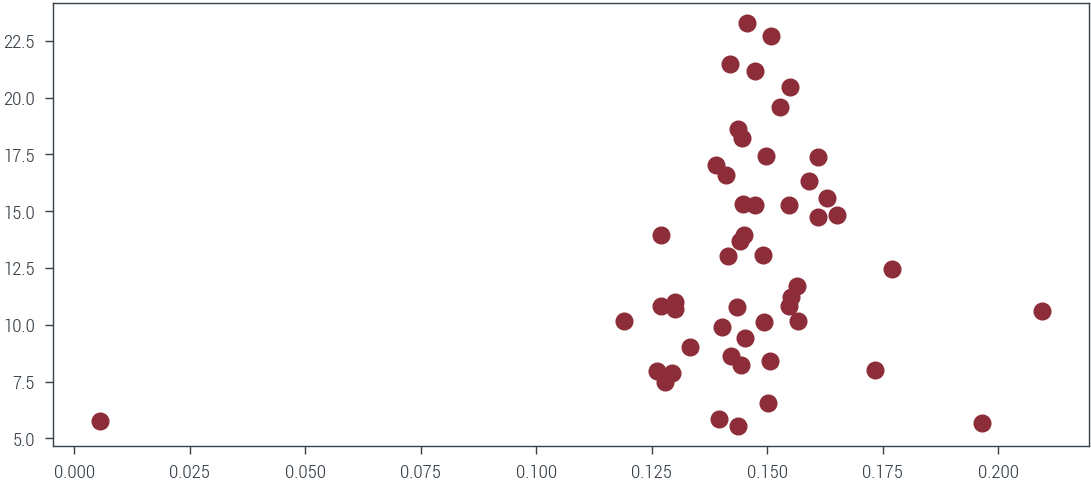

/home/jonathan/.local/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/home/jonathan/.local/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 1102.36x496.063 with 0 Axes>

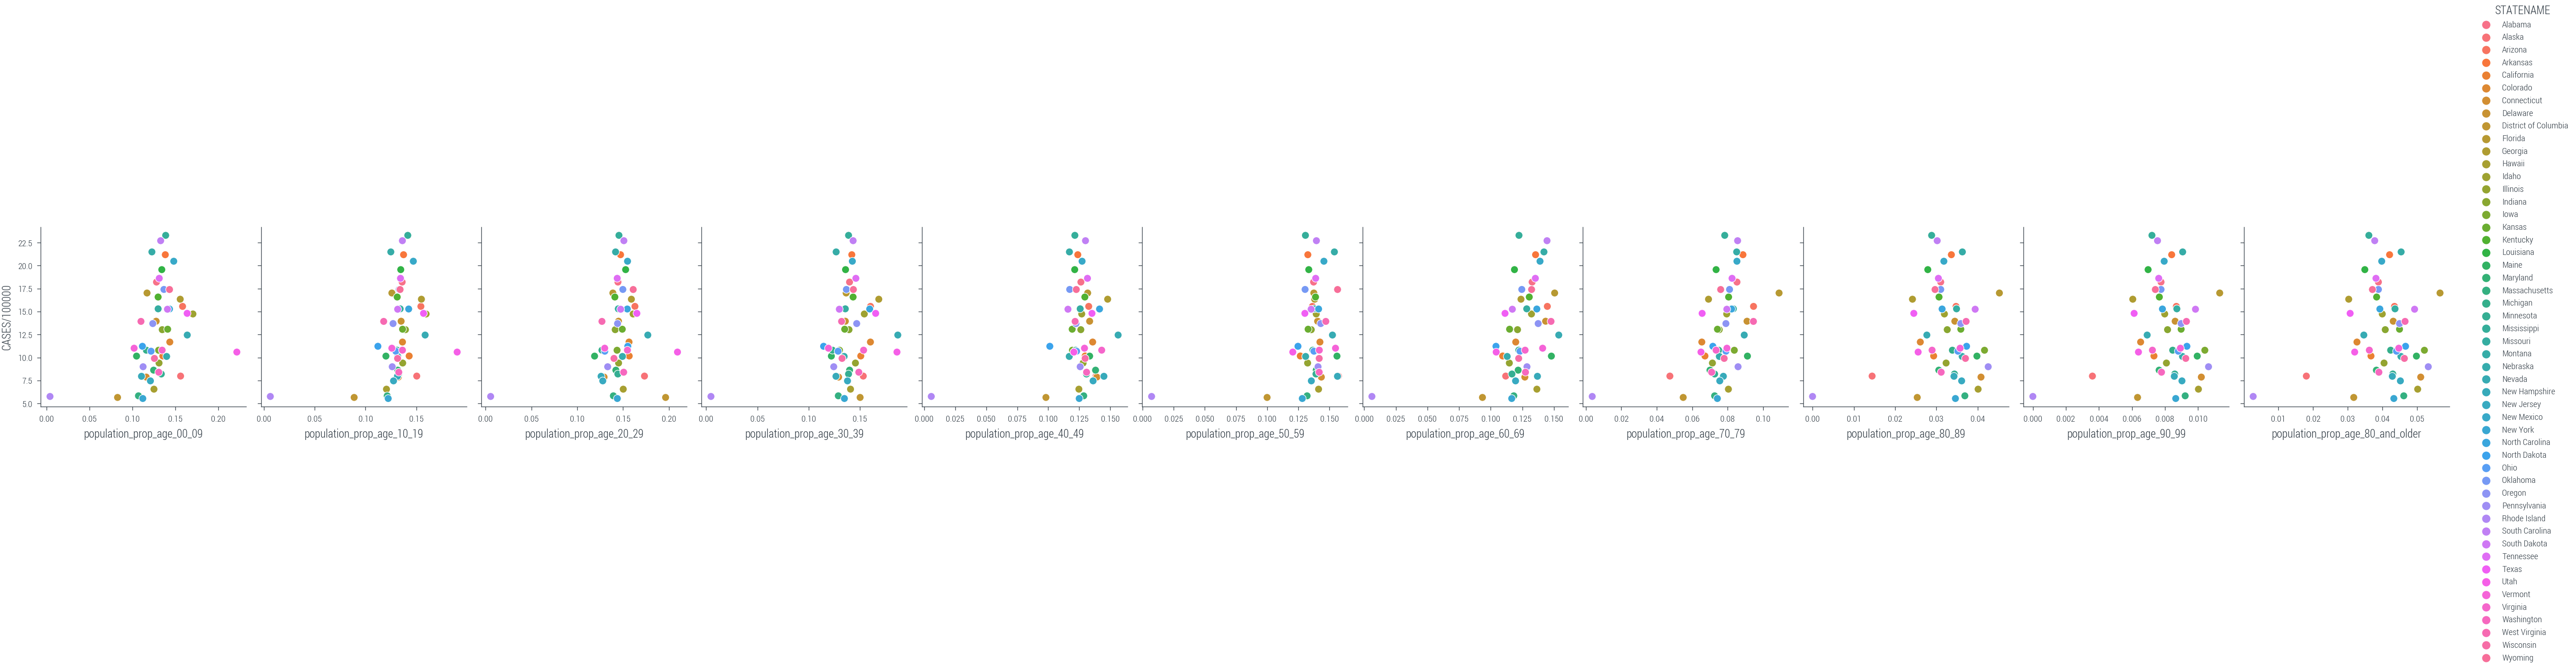

/home/jonathan/.local/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/home/jonathan/.local/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  self._figure.tight_layout(*args, **kwargs)
/home/jonathan/.local/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 1102.36x496.063 with 0 Axes>

/home/jonathan/.local/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


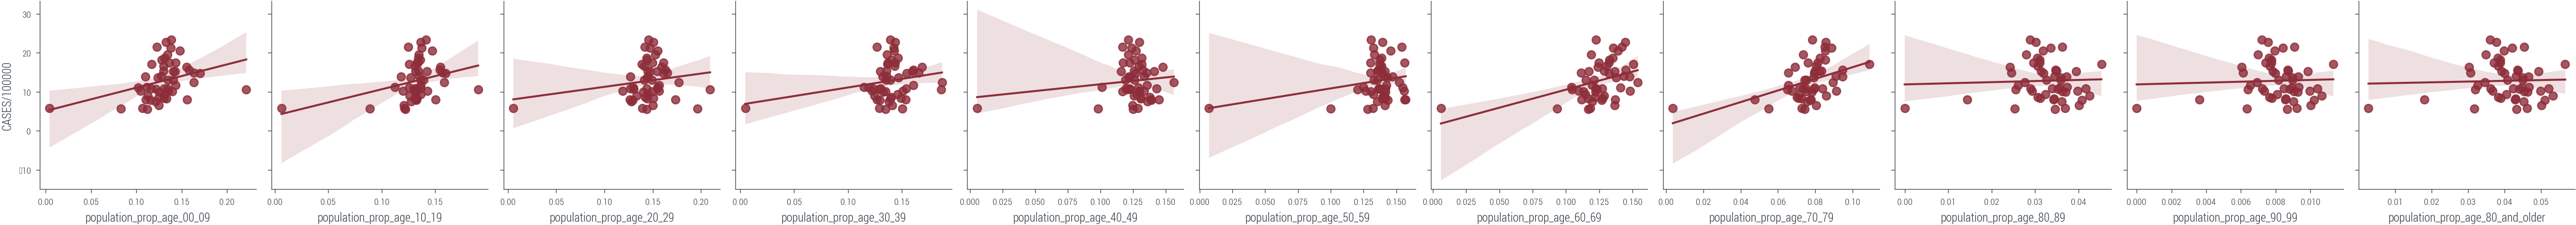

/home/jonathan/.local/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/home/jonathan/.local/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 1102.36x496.063 with 0 Axes>

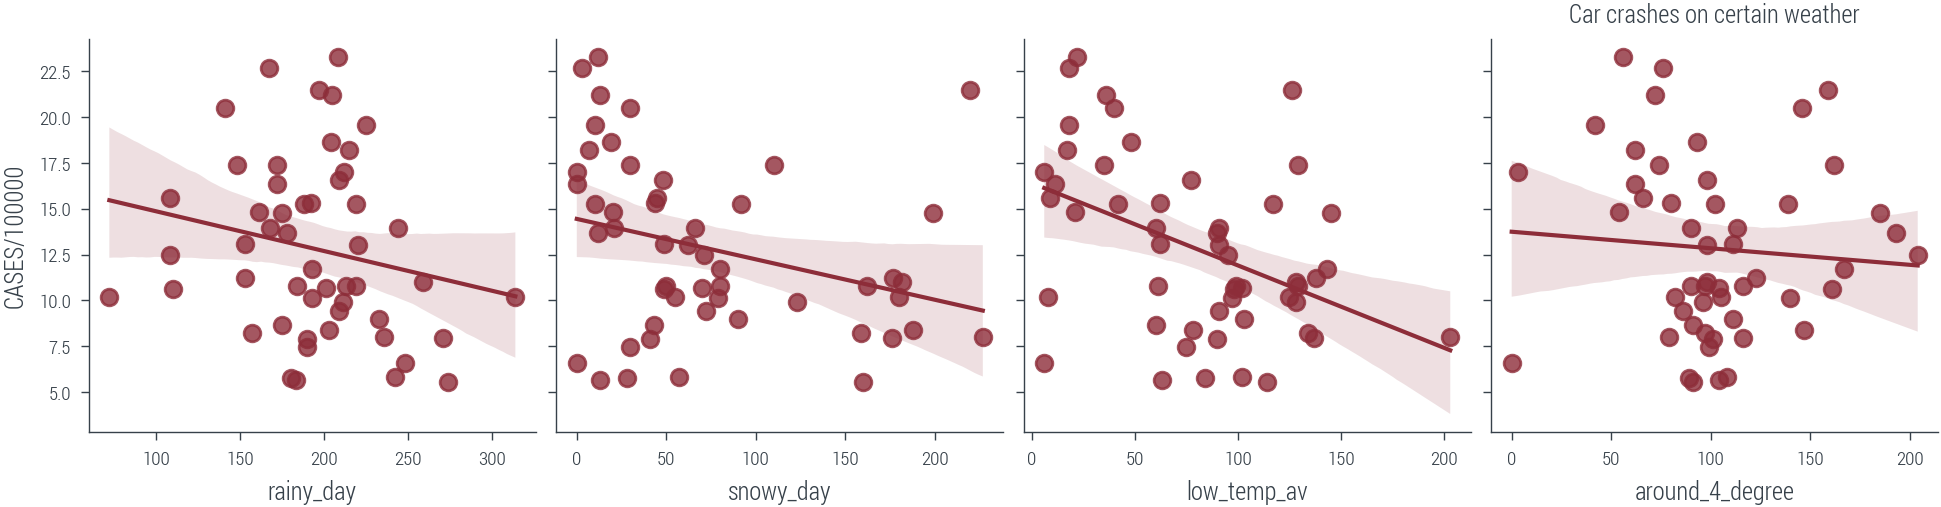

(51, 11)
(1, 51)
[[1.         0.99787333 0.99555522 0.99727237 0.99009489 0.98388354
  0.96838696 0.94506262 0.92471826 0.92471778 0.92471551 0.93895222]
 [0.99787333 1.         0.99867678 0.99902209 0.99600694 0.99193265
  0.97824633 0.95770642 0.94299196 0.94299153 0.94299295 0.93347367]
 [0.99555522 0.99867678 1.         0.99912622 0.99638474 0.99220566
  0.97946069 0.95973141 0.94651853 0.94651812 0.9465203  0.92692345]
 [0.99727237 0.99902209 0.99912622 1.         0.9967161  0.99175739
  0.97923293 0.95847067 0.94252286 0.94252243 0.94252429 0.9329825 ]
 [0.99009489 0.99600694 0.99638474 0.9967161  1.         0.99829025
  0.98999094 0.97378675 0.96323002 0.96322966 0.96322957 0.92921687]
 [0.98388354 0.99193265 0.99220566 0.99175739 0.99829025 1.
  0.99420329 0.98105591 0.97387523 0.9738749  0.9738678  0.9265806 ]
 [0.96838696 0.97824633 0.97946069 0.97923293 0.98999094 0.99420329
  1.         0.99539331 0.98595122 0.98595102 0.98594308 0.93847899]
 [0.94506262 0.95770642 0.959731

In [27]:
population_names = ['population_prop_age_00_09','population_prop_age_10_19','population_prop_age_20_29','population_prop_age_30_39','population_prop_age_40_49','population_prop_age_50_59','population_prop_age_60_69','population_prop_age_70_79','population_prop_age_80_89','population_prop_age_90_99','population_prop_age_80_and_older']
accidents_state[population_names] = 0
print(accidents_state.columns)
#print(accidents_state.loc[:,'population_age_00_09':'population_age_80_and_older'].sum(axis=0))
accidents_state.loc[:,'population_prop_age_00_09':'population_prop_age_80_and_older'] = accidents_state.loc[:,'population_age_00_09':'population_age_80_and_older'].to_numpy()/accidents_state['Population'].to_numpy().reshape(-1,1)

#print(accidents_state.loc[:,'population_prop_age_00_09':'population_prop_age_90_99'].sum(axis=1).max())
print(accidents_state)
#accidents_state.loc[:,'population_prop_age_00_09':'population_prop_age_80_and_older'] = accidents_state.loc[:,'population_prop_age_00_09':'population_prop_age_80_and_older'].div(accidents_state['Population'])


print(accidents_state)

plt.figure()
plt.scatter(accidents_state['population_prop_age_20_29'],accidents_state['CASES/100000'])
plt.show()

plt.figure()
sns.pairplot(accidents_state,y_vars=['CASES/100000'],x_vars=population_names,hue='STATENAME')
plt.show()

plt.figure()
sns.pairplot(accidents_state,y_vars=['CASES/100000'],x_vars=population_names,kind='reg')#,hue='STATENAME'
plt.show()

plt.figure()
sns.pairplot(accidents_state,y_vars=['CASES/100000'],x_vars=['rainy_day','snowy_day','low_temp_av','around_4_degree'],kind='reg')
plt.title('Car crashes on certain weather')
plt.show()



#plt.figure()
#sns.pairplot(accidents_state,y_vars=['CASES_'])

print(accidents_state.loc[:,'population_age_00_09':'population_age_80_and_older'].to_numpy().shape)
print(accidents_state.loc[:,'CASES/100000'].to_numpy().reshape((1,-1)).shape)
corr = np.corrcoef(accidents_state.loc[:,'population_age_00_09':'population_age_80_and_older'].to_numpy().T,accidents_state.loc[:,'CASES'].to_numpy().reshape((1,-1)))
print(corr)





## List cases

HOUR           0    1    2    3    4    5    6    7    8    9   ...   14   15  \
DAY_WEEKNAME                                                    ...             
Friday        187  167  208  153  126  186  224  211  169  165  ...  262  314   
Monday        214  179  170  142  134  162  205  212  150  149  ...  239  248   
Saturday      347  381  380  275  170  152  159  160  141  135  ...  256  291   
Sunday        399  336  416  335  220  180  157  138  106  116  ...  243  276   
Thursday      165  153  161  105  135  180  221  182  153  154  ...  234  305   
Tuesday       168  116   97  101   94  155  186  206  145  131  ...  251  266   
Wednesday     150  106  115   94  100  165  189  162  160  134  ...  267  261   

HOUR           16   17   18   19   20   21   22   23  
DAY_WEEKNAME                                          
Friday        311  343  391  381  403  424  416  388  
Monday        267  266  314  290  280  287  221  168  
Saturday      302  310  399  389  372  411  388  4

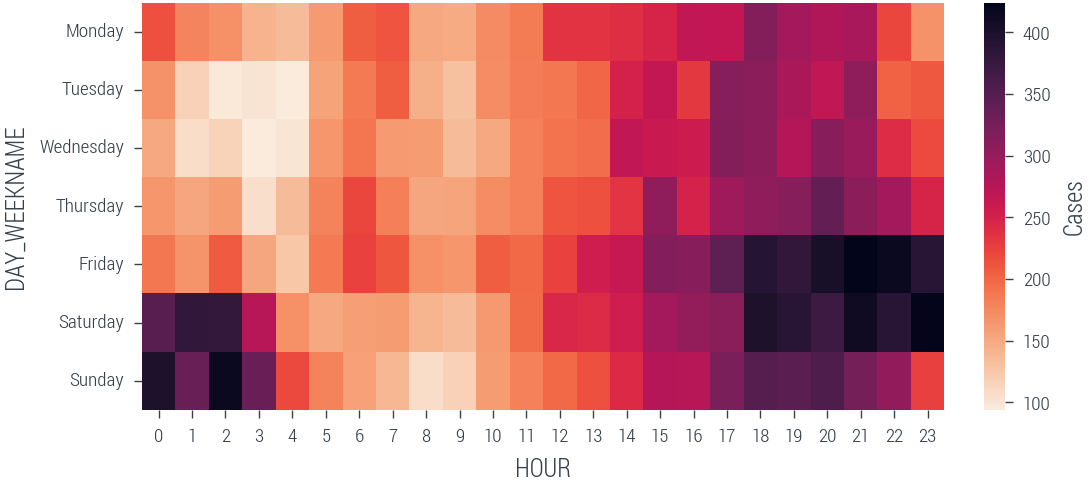

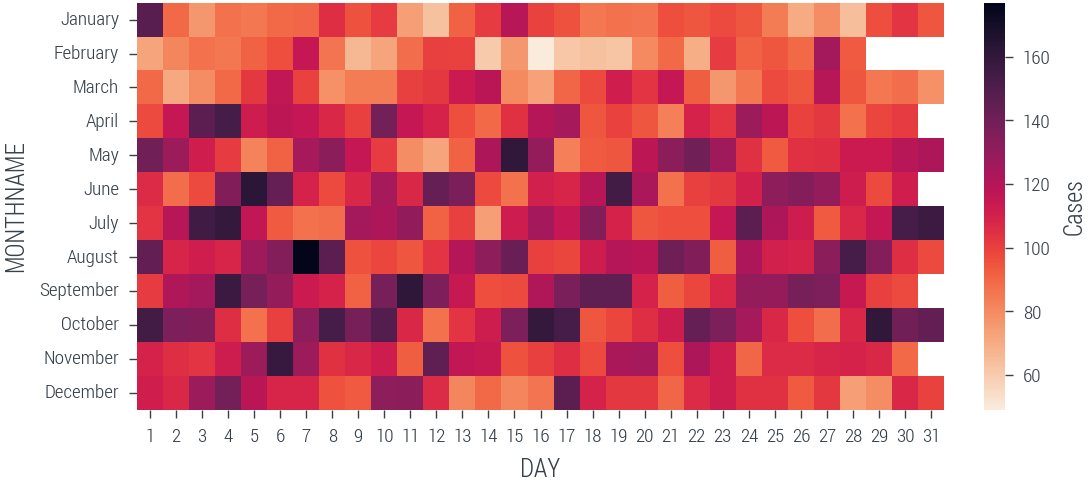

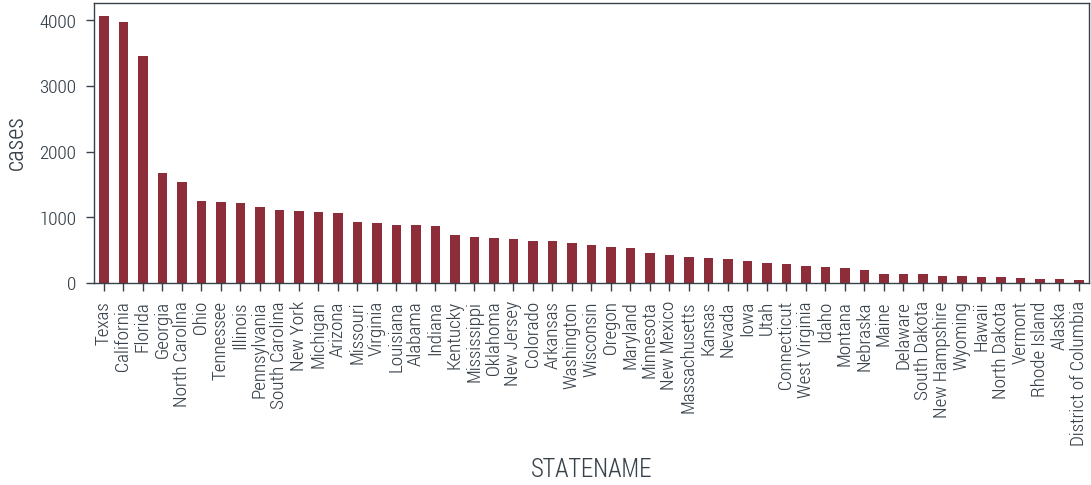

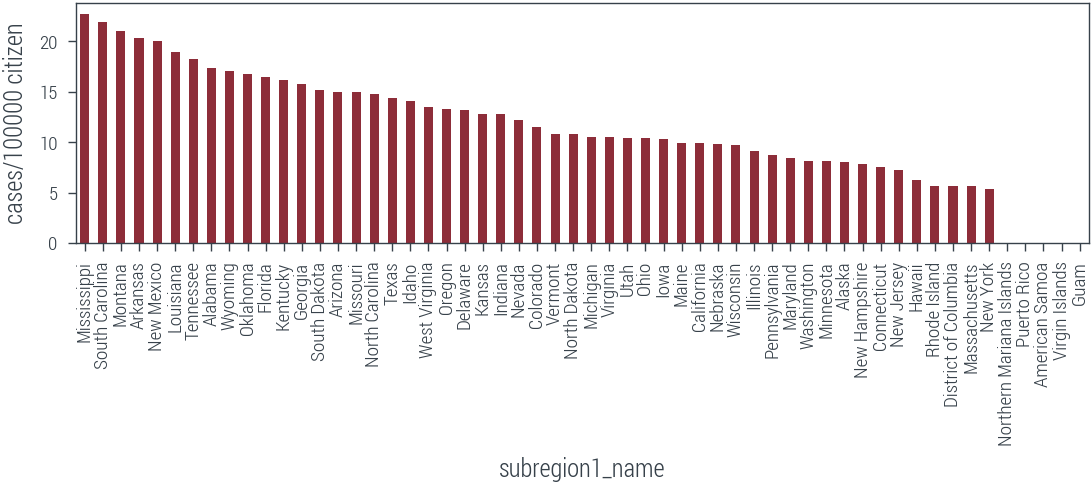

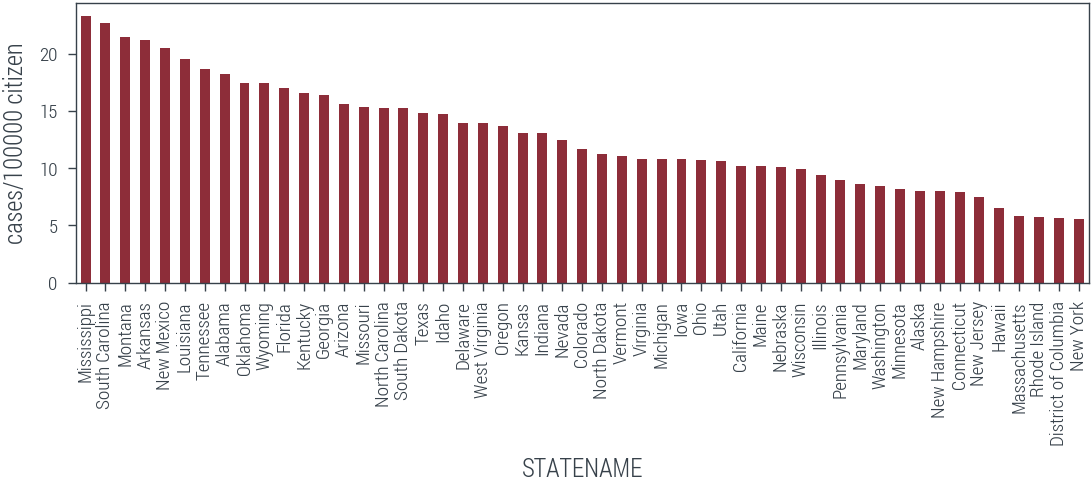

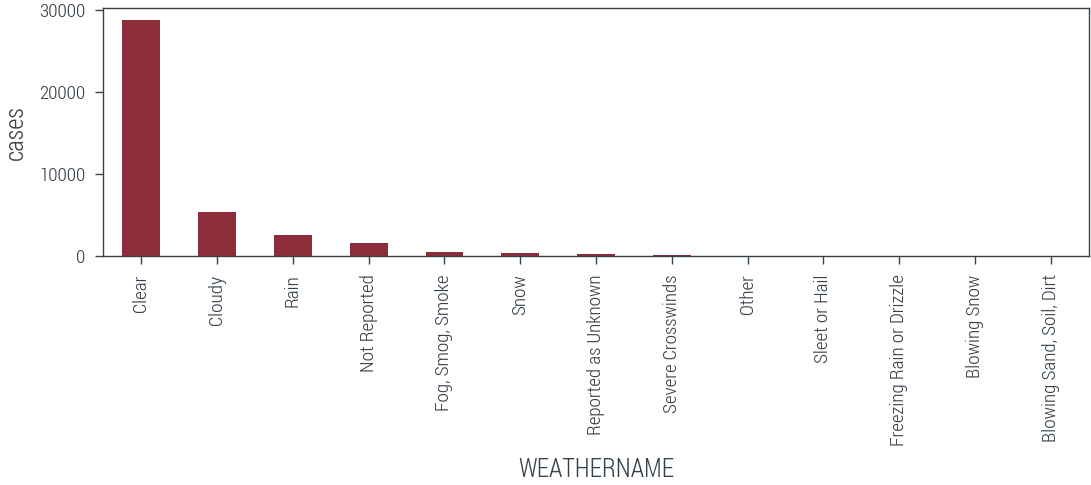

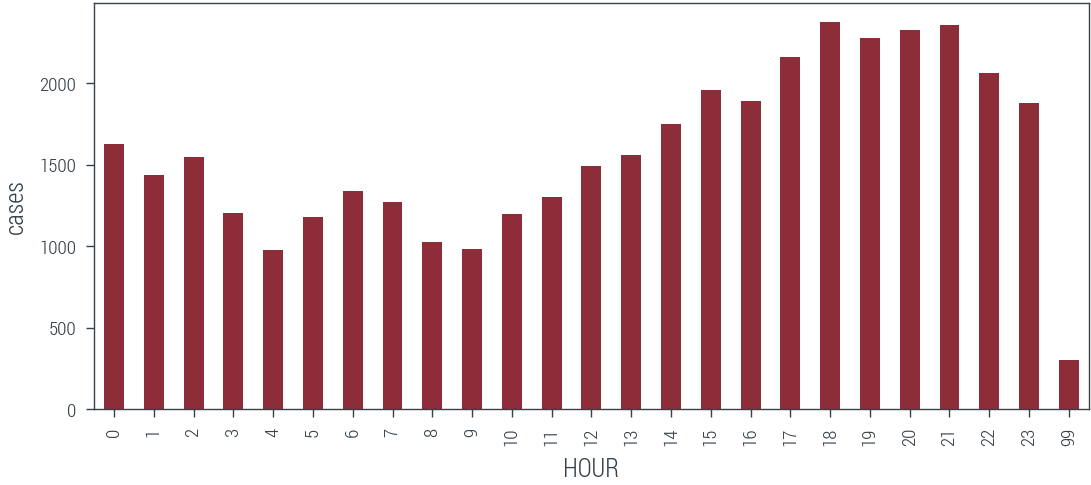

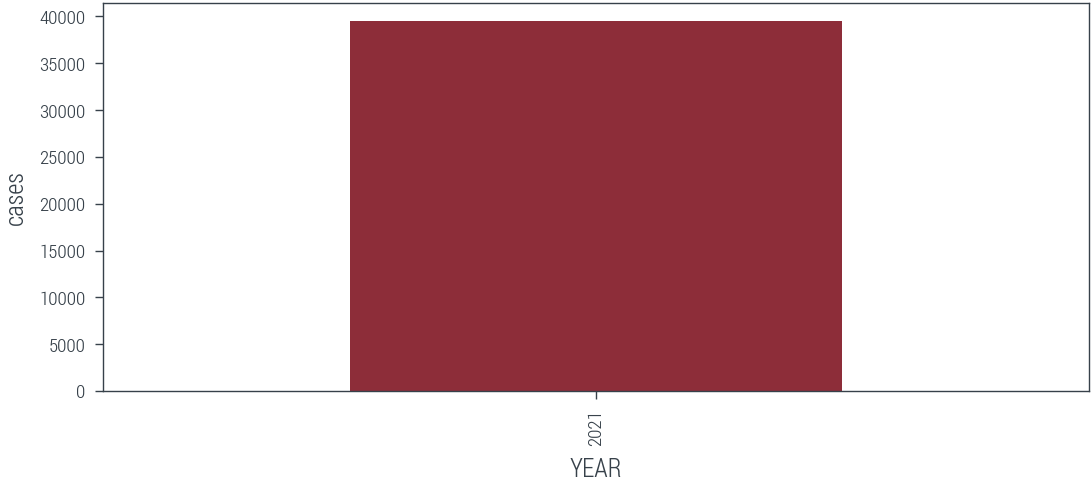

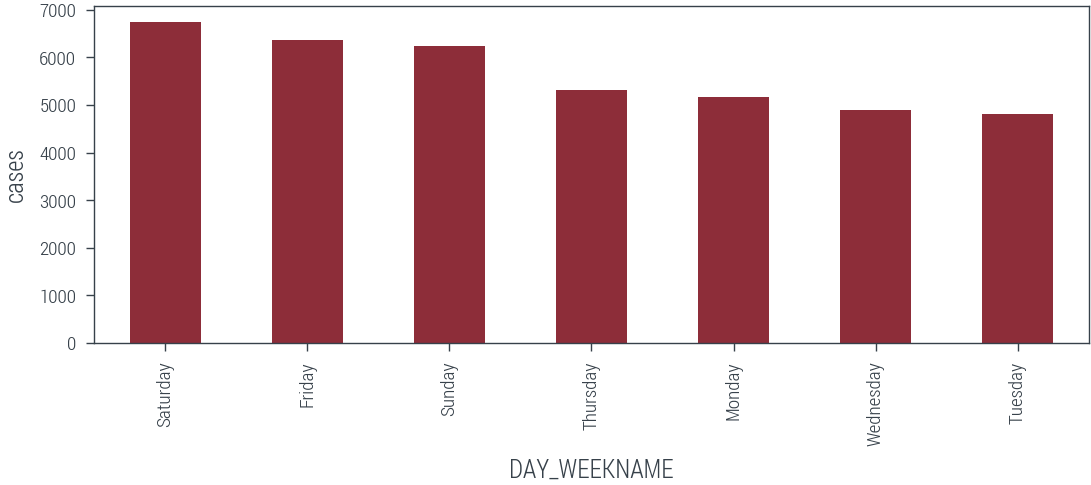

<Figure size 1102.36x496.063 with 0 Axes>

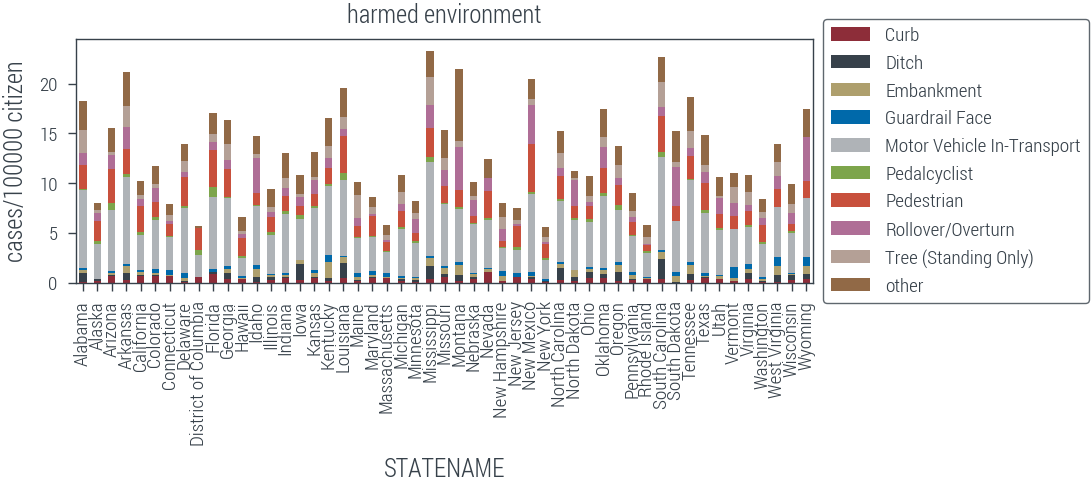

<Figure size 1102.36x496.063 with 0 Axes>

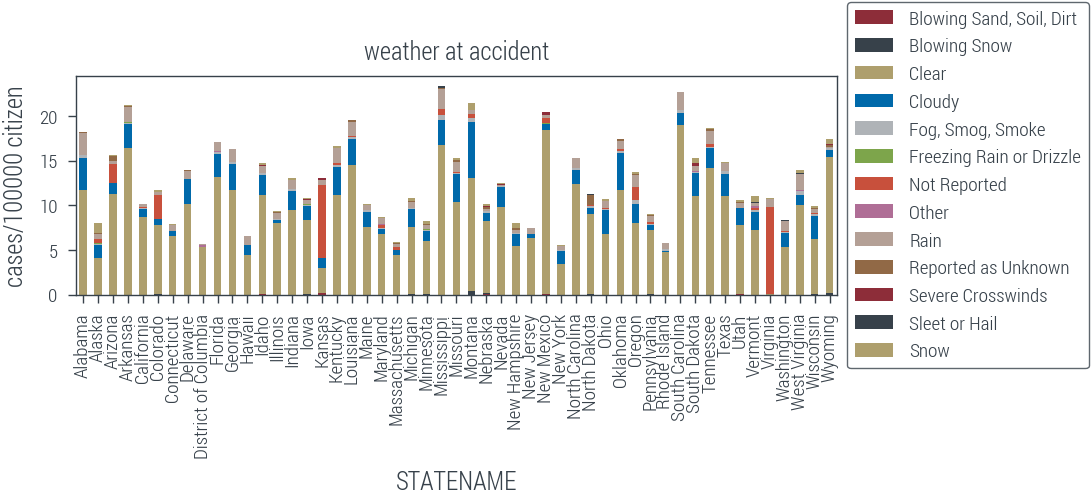

In [ ]:
#print(accidents[accidents['HOUR']!=99,'HOUR'].apply(pd.value_counts))
print(accidents[accidents['HOUR']!=99].groupby(['DAY_WEEKNAME','HOUR']).size().unstack())

plt.figure()
#plt.hist2d(accidents[accidents['HOUR']!=99].groupby(['DAY_WEEKNAME','HOUR']).size())
sns.heatmap(accidents[accidents['HOUR']!=99].groupby(['DAY_WEEKNAME','HOUR']).size().unstack().loc[['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'],:],cbar_kws={'label':'Cases'},cmap=sns.cm.rocket_r)
#plt.title()
plt.show()


plt.figure()
sns.heatmap(accidents.groupby(['MONTHNAME','DAY']).size().unstack().loc[['January','February','March','April','May','June','July','August','September','October','November','December'],:],cbar_kws={'label':'Cases'},cmap=sns.cm.rocket_r)
plt.show()

plt.figure()
accidents['STATENAME'].value_counts().plot.bar()
plt.ylabel('cases')
plt.show()

plt.figure()

Google_daten.groupby('subregion1_name')['CASES/100000'].sum().sort_values(ascending=False).plot(kind='bar')
#Google_daten.groupby('subregion1_name')['mobility_workspaces'].first().plot(kind='bar')
plt.ylabel('cases/100000 citizen')
plt.show()


plt.figure()
#plt.title('cases per 100000 habitants')
accidents_state.set_index('STATENAME')['CASES/100000'].sort_values(ascending=False).plot.bar()
plt.ylabel('cases/100000 citizen')
plt.show()

plt.figure()
accidents['WEATHERNAME'].value_counts().plot.bar()
plt.ylabel('cases')
plt.show()

plt.figure()
accidents['HOUR'].value_counts().sort_index().plot.bar()
plt.ylabel('cases')
plt.show()

plt.figure()
accidents['YEAR'].value_counts().sort_index().plot.bar()
plt.ylabel('cases')
plt.show()

plt.figure()
accidents['DAY_WEEKNAME'].value_counts().plot.bar()
plt.ylabel('cases')
plt.show()


accidents['HARM_EVNAME'] = accidents['HARM_EVNAME'].replace(accidents['HARM_EVNAME'].value_counts().index[10:],'other')

plt.figure()
accidents.groupby(['STATENAME','HARM_EVNAME']).size().unstack().div(accidents_state.set_index('STATENAME')['Population']/100000,axis=0).plot(kind='bar',stacked=True)
plt.ylabel('cases/100000 citizen')
plt.title('harmed environment')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure()
accidents.groupby(['STATENAME','WEATHERNAME']).size().unstack().div(accidents_state.set_index('STATENAME')['Population']/100000,axis=0).plot(kind='bar',stacked=True)
plt.ylabel('cases/100000 citizen')
plt.title('weather at accident')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

## Geo Plot


/home/jonathan/.local/lib/python3.11/site-packages/geopandas/plotting.py:967: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  plt.draw()


(20.0, 73.98790205)

/home/jonathan/.local/lib/python3.11/site-packages/IPython/core/events.py:93: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  func(*args, **kwargs)
/home/jonathan/.local/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


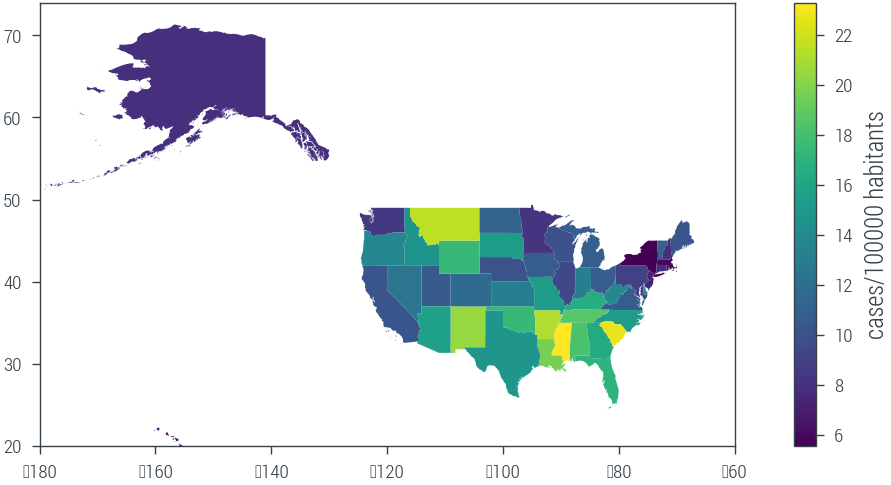

In [50]:
US_state_shape = save_US.copy()
US_state_shape = geopandas.GeoDataFrame(pd.merge(US_state_shape,accidents_state, on=['STATENAME']))

US_state_shape.plot(column='CASES/100000',legend=True,legend_kwds={'label':'cases/100000 habitants'})
plt.xlim(-180,-60)
plt.ylim(20,None)